In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from scipy.stats import ttest_ind, mannwhitneyu
from scipy import stats
# Regression imports
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
# Classification imports
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler

#############################################
# Data Cleaning
#############################################
# Load the dataset
df = pd.read_csv('surv_variants_updated.csv')
df.columns = df.columns.str.strip()  # Remove any leading/trailing whitespace
print("Initial Data Info:")
print(df.info())
print("\nInitial Data Head:")
print(df.head())
print("\nSummary Statistics:")
print(df.describe())
print("--------------------------------------------------\n")

# Remove duplicate rows
num_duplicates = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {num_duplicates}")
if num_duplicates > 0:
    df = df.drop_duplicates()
    print("Duplicates have been removed.")
print("--------------------------------------------------\n")

# Check for missing values (NaN) and zeros for specific columns
missing = df.isnull().sum()
print("\nMissing values per column (NaN):")
print(missing)
print("--------------------------------------------------\n")

# Handle missing values (NaN):
# For numeric columns, fill missing values with the median.
# For categorical columns, fill missing values with the mode.
for col in df.columns:
    if df[col].dtype in ['float64', 'int64']:
        df[col] = df[col].fillna(df[col].median())
    else:
        df[col] = df[col].fillna(df[col].mode()[0] if not df[col].mode().empty else "Unknown")
print("Missing (NaN) values have been handled.")
print("--------------------------------------------------\n")

# Specific handling for zeros representing missing values in key columns.
# We'll assume that missing data in total_cases, total_deaths, and mortality_rate are recorded as 0.
# We'll group by 'country' and 'variant' if available.
group_cols = []
if 'Country' in df.columns:
    group_cols.append('Country')
if 'variant' in df.columns:
    group_cols.append('variant')
print("Group columns:", group_cols)

# For total_cases and total_deaths: replace zeros with NaN and impute.
for col in ['total_cases', 'total_deaths']:
    if col in df.columns:
        print(f"Processing group-based imputation for {col}")
        df[col] = df[col].replace(0, np.nan)
        if group_cols:
            df[col] = df.groupby(group_cols)[col].transform(lambda x: x.fillna(x.median()))
        df[col] = df[col].fillna(df[col].median())
    else:
        print(f"Column {col} not found.")

# For mortality_rate: replace zeros with NaN and impute.
if 'mortality_rate' in df.columns:
    print("Processing mortality_rate adjustments")
    df['mortality_rate'] = df['mortality_rate'].replace(0, np.nan)
    if group_cols:
        df['mortality_rate'] = df.groupby(group_cols)['mortality_rate'].transform(lambda x: x.fillna(x.median()))
    df['mortality_rate'] = df['mortality_rate'].fillna(df['mortality_rate'].median())
else:
    print("Column 'mortality_rate' not found.")

# Ensure internal consistency:
# For rows where total_cases is nonzero:
mask = df['total_cases'].notna() & (df['total_cases'] != 0)
# 1. If mortality_rate is missing or zero, recalculate it as total_deaths / total_cases.
df.loc[mask & (df['mortality_rate'].isna() | (df['mortality_rate'] == 0)),
       'mortality_rate'] = df['total_deaths'] / df['total_cases']
# 2. If total_deaths is missing or zero but mortality_rate is valid, infer total_deaths.
df.loc[mask & ((df['total_deaths'].isna()) | (df['total_deaths'] == 0)) &
       (df['mortality_rate'].notna()) & (df['mortality_rate'] != 0),
       'total_deaths'] = df['total_cases'] * df['mortality_rate']
# 3. Recalculate mortality_rate for all rows with nonzero total_cases for final consistency.
df.loc[mask, 'mortality_rate'] = df['total_deaths'] / df['total_cases']

print("Checkpoint 5: Specific handling for zeros and consistency adjustments complete.")
print("--------------------------------------------------\n")

# Date conversion and duration calculation using 'first_seq' and 'last_seq'
if 'first_seq' in df.columns and 'last_seq' in df.columns:
    print("Processing date conversion and duration calculation using 'first_seq' and 'last_seq'...")
    df['first_seq'] = pd.to_datetime(df['first_seq'], errors='coerce')
    df['last_seq'] = pd.to_datetime(df['last_seq'], errors='coerce')
    # Calculate duration using the earlier date as the start and the later date as the end
    df['duration'] = (df[['first_seq', 'last_seq']].max(axis=1) - df[['first_seq', 'last_seq']].min(axis=1)).dt.days + 1
    print("After duration calculation, min duration:", df['duration'].min())
    print("Duration column calculated based on 'first_seq' and 'last_seq', with minimum value set to 1.")
else:
    print("Either 'first_seq' or 'last_seq' column is missing; skipping duration calculation.")
print("--------------------------------------------------\n")

# Outlier detection and removal using the IQR method for numeric columns
IQR_multiplier = 3     # Increased from 1.5 to 3 to reduce removal of legitimate data
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
outlier_mask = pd.Series(False, index=df.index)
print("\nOutlier removal process:")
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - IQR_multiplier * IQR
    upper_bound = Q3 + IQR_multiplier * IQR
    # Mark rows as outliers if any numeric column falls outside its bounds
    outlier_mask |= (df[col] < lower_bound) | (df[col] > upper_bound)
    print(f"Column '{col}': Lower bound = {lower_bound}, Upper bound = {upper_bound}")
# Filter the dataframe to remove outliers
df = df[~outlier_mask]
print("\nCleaned data shape after outlier removal:", df.shape)
print("--------------------------------------------------\n")

# Fix data formatting issues:
# Trim whitespace from string columns
str_cols = df.select_dtypes(include=['object']).columns
for col in str_cols:
    df[col] = df[col].str.strip()
if 'date' in df.columns: # Optionally, convert a generic 'date' column to datetime if it exists
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
print("Converted 'date' column to datetime format.")
print("--------------------------------------------------\n")

# Final inspection of the cleaned data
print("\nCleaned Data Info:")
print(df.info())
print("\nCleaned Data Head:")
print(df.head())
print("\nCleaned Data Tail:")
print(df.tail())
print("--------------------------------------------------\n")

# Grouping by Continent
if 'Continent' in df.columns:
    print("Grouping data by Continent:")
    continents = df['Continent'].unique()
    for cont in sorted(continents):
        cont_df = df[df['Continent'] == cont]
        # Optionally, sort by country if available
        if 'country' in cont_df.columns:
            cont_df = cont_df.sort_values(by='country')
        print(f"Continent: {cont}, Number of records: {len(cont_df)}")
        # Save each continent's data to a separate CSV file
        cont_file = f"surv_variants_cleaned_{cont}.csv"
        cont_df.to_csv(cont_file, index=False)
        print(f"Saved data for {cont} to {cont_file}")
else:
    print("No 'Continent' column found. Skipping grouping by continent.")

# Save the cleaned DataFrame to a new CSV file
cleaned_file_path = 'surv_variants_cleaned.csv'
df.to_csv(cleaned_file_path, index=False)
print(f"\nCleaned data saved to {cleaned_file_path}")
print("--------------------------------------------------\n")

Initial Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4097 entries, 0 to 4096
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country         4097 non-null   object 
 1   variant         4097 non-null   object 
 2   first_seq       4097 non-null   object 
 3   last_seq        4097 non-null   object 
 4   duration        4097 non-null   int64  
 5   mortality_rate  4097 non-null   float64
 6   total_cases     4097 non-null   float64
 7   total_deaths    4097 non-null   float64
 8   growth_rate     3569 non-null   float64
 9   Continent       4097 non-null   object 
dtypes: float64(4), int64(1), object(5)
memory usage: 320.2+ KB
None

Initial Data Head:
       Country      variant  first_seq    last_seq  duration  mortality_rate  \
0  Afghanistan       S.Q677  1/21/2021    6/3/2020         0        0.043435   
1  Afghanistan       S.N501  3/21/2021  11/19/2021        69        0.041349   
2  Af


 Descriptive Statistics:
+-------+----------+----------------+-------------+--------------+-------------+
|       | duration | mortality_rate | total_cases | total_deaths | growth_rate |
+-------+----------+----------------+-------------+--------------+-------------+
| count |  3116.0  |     3116.0     |   3116.0    |    3116.0    |   3116.0    |
| mean  | 187.689  |     0.018      |  4707.544   |    80.278    |  1204.825   |
|  std  | 127.959  |     0.011      |  9368.208   |   166.335    |  1842.165   |
|  min  |   1.0    |      0.0       |    0.083    |     0.0      |     0.0     |
|  25%  |   85.0   |     0.011      |   78.257    |    0.945     |   129.723   |
|  50%  |  170.0   |     0.016      |   703.592   |    10.283    |   701.685   |
|  75%  |  268.0   |     0.023      |  4033.003   |    66.489    |  1133.833   |
|  max  |  758.0   |     0.064      |  56620.899  |   979.831    |  10629.928  |
+-------+----------+----------------+-------------+--------------+-------------+

 

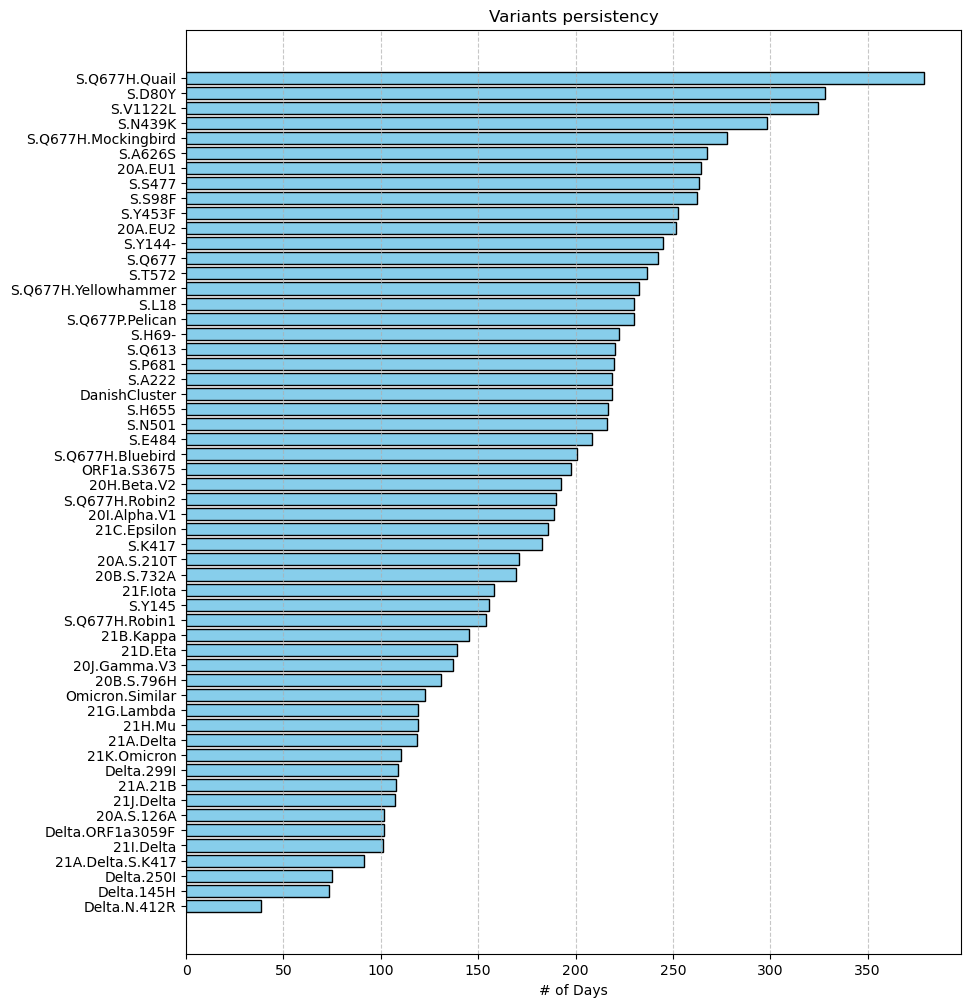

--------------------------------------------------



In [4]:

#############################################
# Summary Statistics
#############################################
def generate_summary_statistics_limited(df):
    summary = {}

    numerical_columns = df.select_dtypes(include=['number']).drop(columns=['first_seq', 'last_seq'], errors='ignore')
    summary['Descriptive Statistics'] = numerical_columns.describe().round(3)

    # unique count
    unique_values = pd.DataFrame({
        'Metric': ['Countries', 'Variants', 'Continents'],
        'Unique Count': [df['Country'].nunique(), df['variant'].nunique(), df['Continent'].nunique()]
    })

    summary['Unique Values'] = unique_values

    return summary

#generate statistics
summary_statistics = generate_summary_statistics_limited(df)

print("\n Descriptive Statistics:")
print(tabulate(summary_statistics['Descriptive Statistics'], headers='keys', tablefmt='pretty'))

print("\n Unique Values:")
print(tabulate(summary_statistics['Unique Values'], headers='keys', tablefmt='pretty'))

# top 10 countries with the highest number of cases
top_10_cases = df.groupby('Country')['total_cases'].sum().nlargest(10).reset_index()
top_10_cases['total_cases'] = top_10_cases['total_cases'].astype(int).apply(lambda x: f"{x:,}")

# top 10 countries with the highest number of deaths
top_10_deaths = df.groupby('Country')['total_deaths'].sum().nlargest(10).reset_index()
top_10_deaths['total_deaths'] = top_10_deaths['total_deaths'].astype(int).apply(lambda x: f"{x:,}")

print("\n Top 10 Countries by Total Cases:")
print(tabulate(top_10_cases, headers='keys', tablefmt='pretty', numalign="right"))

print("\n Top 10 Countries by Total Deaths:")
print(tabulate(top_10_deaths, headers='keys', tablefmt='pretty', numalign="right"))

# mean duration by variant
mean_duration_by_variant = df.groupby('variant')['duration'].mean().reset_index()
mean_duration_by_variant = mean_duration_by_variant.sort_values(by='duration', ascending=False)

fig, ax = plt.subplots(figsize=(10, 12))
y_positions = range(len(mean_duration_by_variant))
ax.barh(y_positions, mean_duration_by_variant['duration'], color='skyblue', edgecolor='black', align='center')

ax.set_yticks(y_positions)
ax.set_yticklabels(mean_duration_by_variant['variant'])

ax.set_xlabel("# of Days")
ax.set_title("Variants persistency")

ax.invert_yaxis()
ax.grid(axis='x', linestyle='--', alpha=0.7)

plt.show()
print("--------------------------------------------------\n")

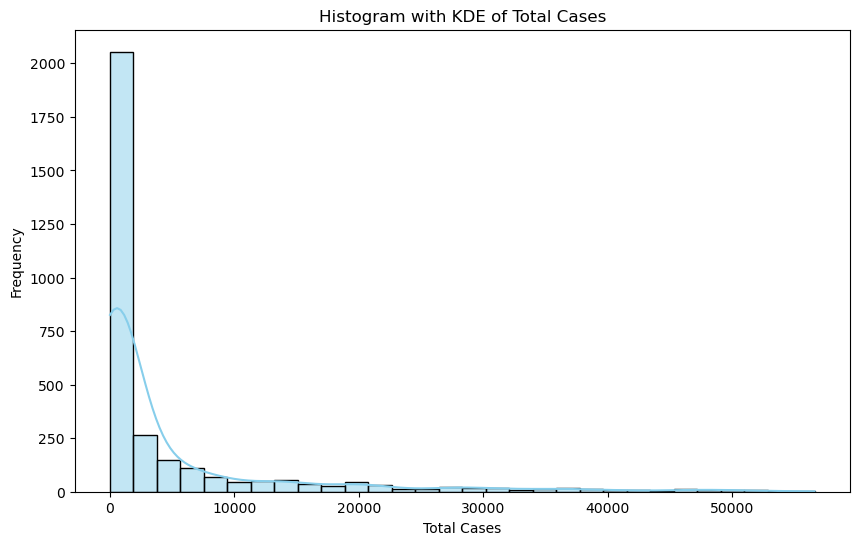

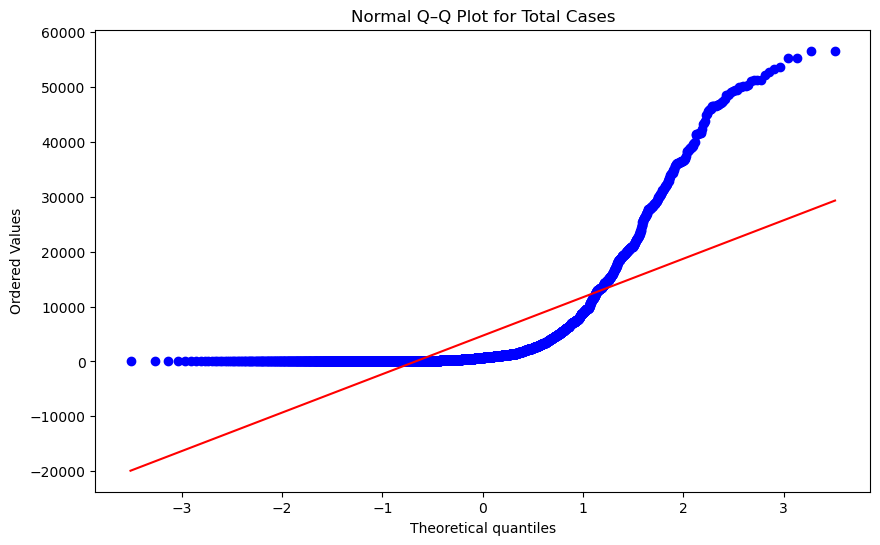

[Total Cases] Fitted Normal: mu = 4707.54, sigma = 9366.70
[Total Cases] Fitted Lognormal: shape = 2.68, loc = 0.00, scale = 502.73


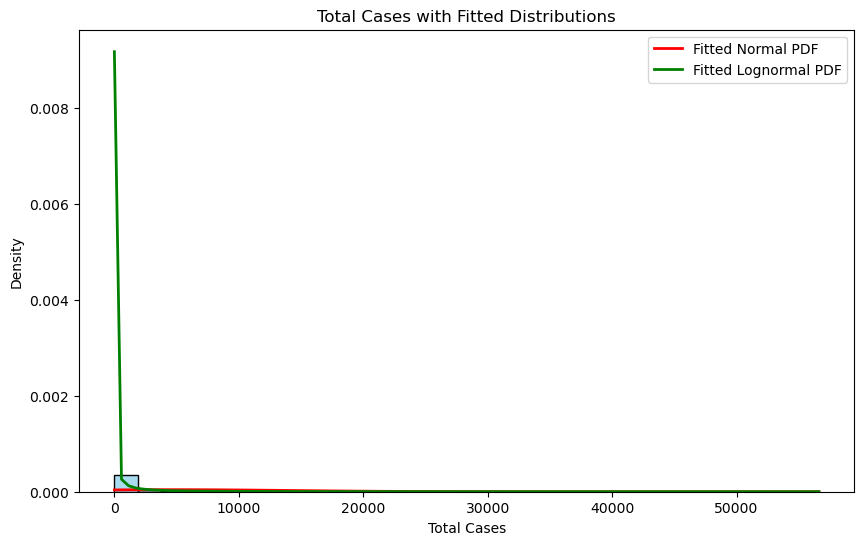


--- Total Cases Distribution Comparison ---
Normal Distribution: AIC = 65837.95, K-S p-value = 0.0000
Lognormal Distribution: AIC = 53757.03, K-S p-value = 0.0000


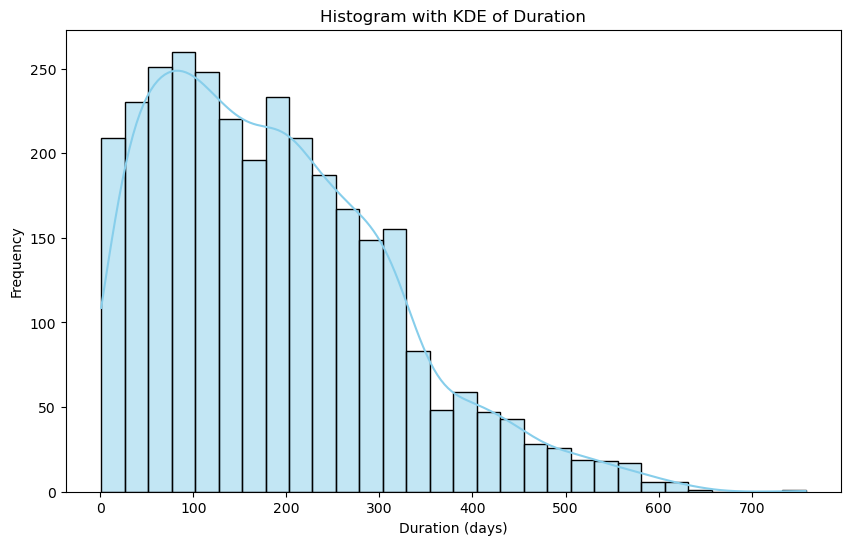

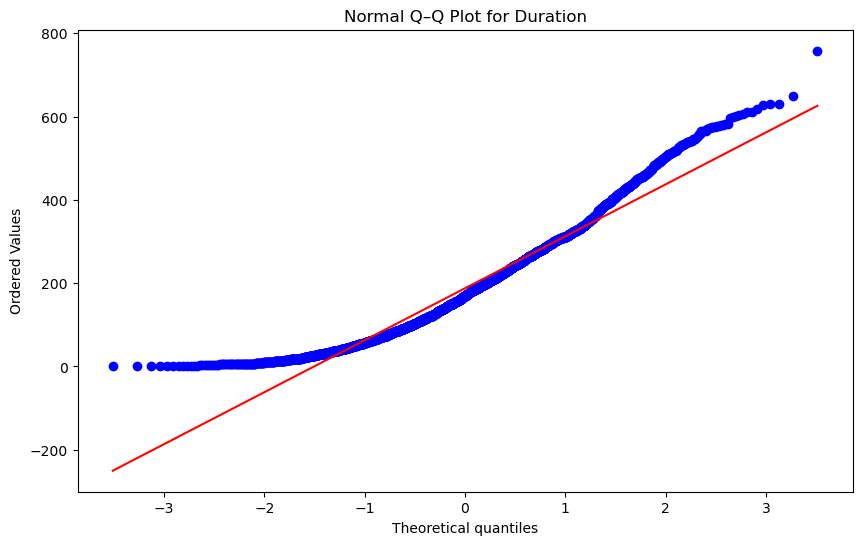

[Duration] Fitted Normal: mu = 187.69, sigma = 127.94
[Duration] Fitted Lognormal: shape = 0.97, loc = 0.00, scale = 134.64


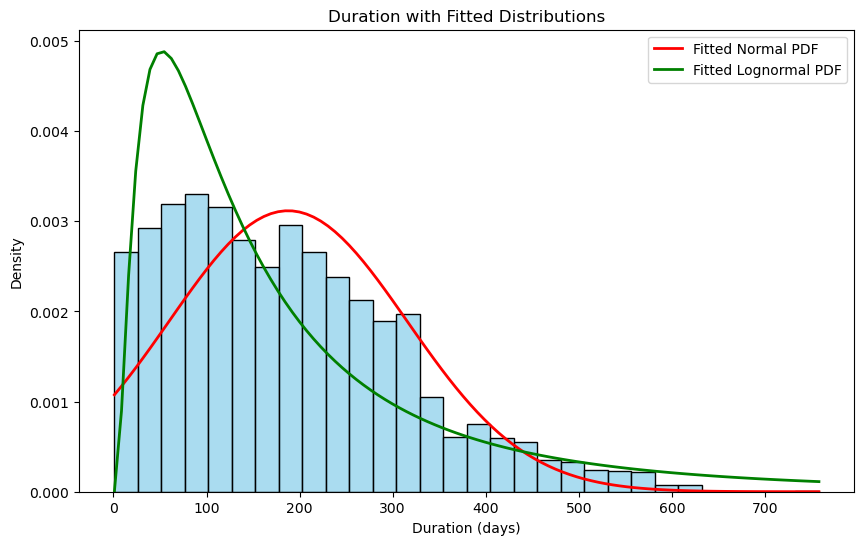


--- Duration Distribution Comparison ---
Normal Distribution: AIC = 39081.69, K-S p-value = 0.0000
Lognormal Distribution: AIC = 39240.78, K-S p-value = 0.0000


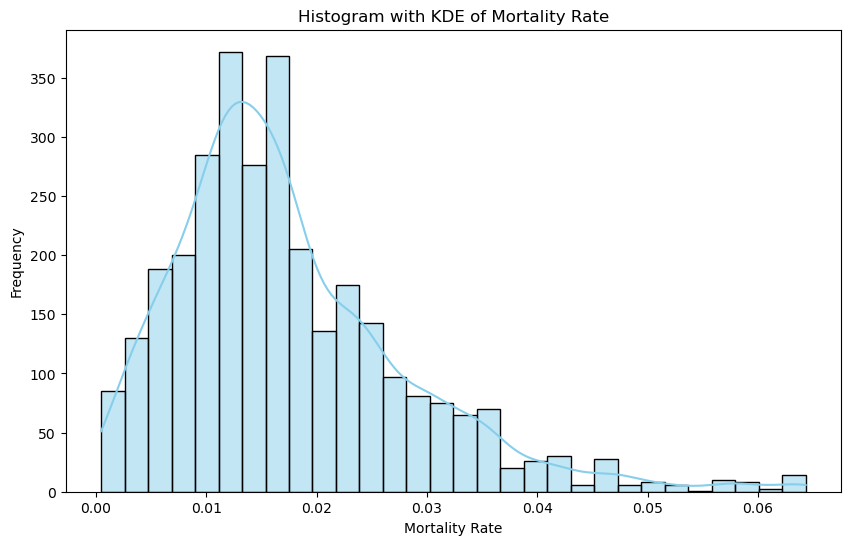

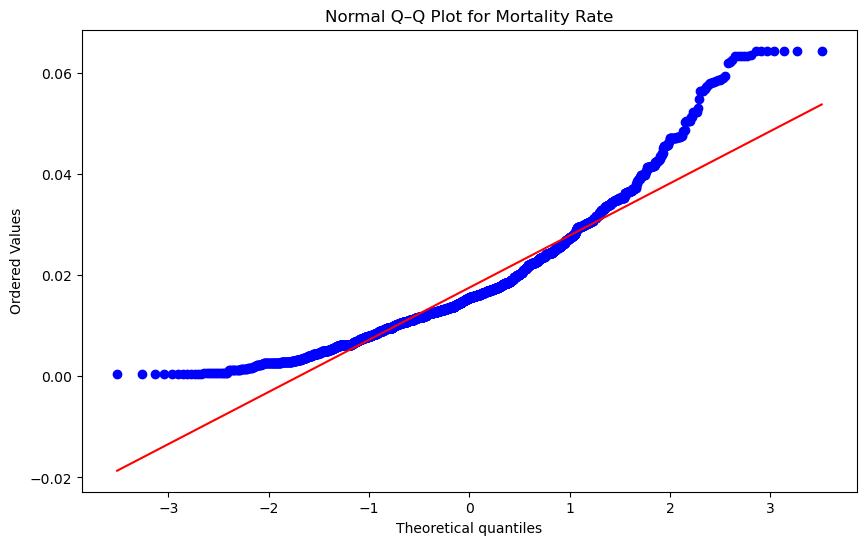

[Mortality Rate] Fitted Normal: mu = 0.0175, sigma = 0.0108
[Mortality Rate] Fitted Lognormal: shape = 0.7216, loc = 0.0000, scale = 0.0142


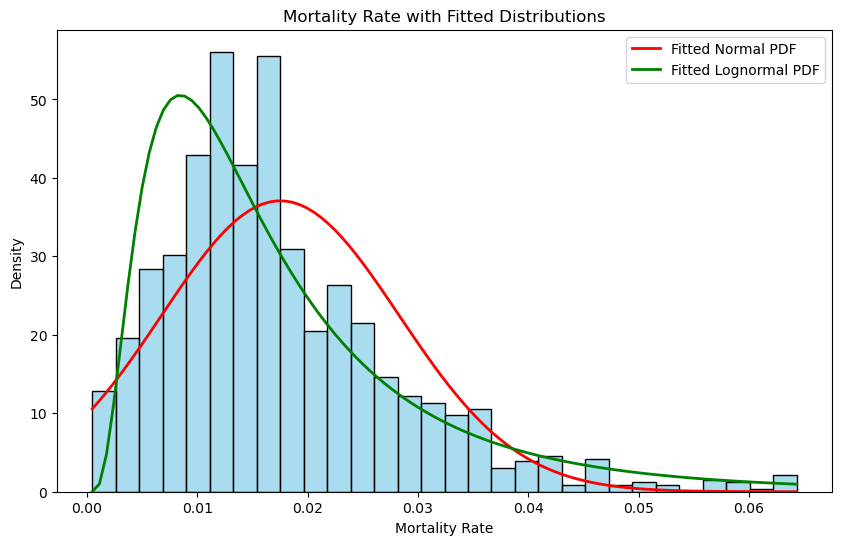


--- Mortality Rate Distribution Comparison ---
Normal Distribution: AIC = -19397.22, K-S p-value = 0.0000
Lognormal Distribution: AIC = -19703.86, K-S p-value = 0.0000
--------------------------------------------------



In [5]:

#############################################
# Types of Distribution/Estimates Parameters
#############################################
# Analysis for "Total Cases"
data_tc = df['total_cases'].dropna()

# Histogram & KDE for Total Cases
plt.figure(figsize=(10, 6))
sns.histplot(data_tc, bins=30, kde=True, color="skyblue", edgecolor="black")
plt.title("Histogram with KDE of Total Cases")
plt.xlabel("Total Cases")
plt.ylabel("Frequency")
plt.show()

# Q–Q Plot for Total Cases (Normality Check)
plt.figure(figsize=(10, 6))
stats.probplot(data_tc, dist="norm", plot=plt)
plt.title("Normal Q–Q Plot for Total Cases")
plt.show()

# Fit a Normal Distribution to Total Cases: # This will estimate the mean and standard deviation (mu and sigma) using maximum likelihood estimation.
mu_tc, sigma_tc = stats.norm.fit(data_tc)
print(f"[Total Cases] Fitted Normal: mu = {mu_tc:.2f}, sigma = {sigma_tc:.2f}")

# Calculate log likelihood and AIC for Normal (Total Cases)
log_likelihood_norm_tc = np.sum(np.log(stats.norm.pdf(data_tc, mu_tc, sigma_tc)))
k_norm = 2  # Two estimated parameters (mu and sigma)
AIC_norm_tc = -2 * log_likelihood_norm_tc + 2 * k_norm
ks_stat_norm_tc, p_value_norm_tc = stats.kstest(data_tc, 'norm', args=(mu_tc, sigma_tc))

# Fit a Lognormal Distribution to Total Cases
ln_shape_tc, ln_loc_tc, ln_scale_tc = stats.lognorm.fit(data_tc, floc=0)
print(f"[Total Cases] Fitted Lognormal: shape = {ln_shape_tc:.2f}, loc = {ln_loc_tc:.2f}, scale = {ln_scale_tc:.2f}")

# Calculate log likelihood and AIC for Lognormal (Total Cases)
log_likelihood_lnorm_tc = np.sum(np.log(stats.lognorm.pdf(data_tc, ln_shape_tc, ln_loc_tc, ln_scale_tc)))
k_lnorm = 2  # We assume loc fixed at 0, so two free parameters: shape and scale.
AIC_lnorm_tc = -2 * log_likelihood_lnorm_tc + 2 * k_lnorm
ks_stat_lnorm_tc, p_value_lnorm_tc = stats.kstest(data_tc, 'lognorm', args=(ln_shape_tc, ln_loc_tc, ln_scale_tc))

# Plot fitted PDFs for Total Cases
x_tc = np.linspace(data_tc.min(), data_tc.max(), 100)
pdf_norm_tc = stats.norm.pdf(x_tc, mu_tc, sigma_tc)
pdf_lnorm_tc = stats.lognorm.pdf(x_tc, ln_shape_tc, ln_loc_tc, ln_scale_tc)

plt.figure(figsize=(10, 6))
sns.histplot(data_tc, bins=30, stat="density", color="skyblue", edgecolor="black", alpha=0.7)
plt.plot(x_tc, pdf_norm_tc, 'r-', lw=2, label="Fitted Normal PDF")
plt.plot(x_tc, pdf_lnorm_tc, 'g-', lw=2, label="Fitted Lognormal PDF")
plt.title("Total Cases with Fitted Distributions")
plt.xlabel("Total Cases")
plt.ylabel("Density")
plt.legend()
plt.show()
# Print Comparison Metrics for Total case
print("\n--- Total Cases Distribution Comparison ---")
print(f"Normal Distribution: AIC = {AIC_norm_tc:.2f}, K-S p-value = {p_value_norm_tc:.4f}")
print(f"Lognormal Distribution: AIC = {AIC_lnorm_tc:.2f}, K-S p-value = {p_value_lnorm_tc:.4f}")

# Analysis for "Duration"
data_duration = df['duration'].dropna()
# Visualization: Histogram, KDE, & Q-Q plot
plt.figure(figsize=(10, 6))
sns.histplot(data_duration, bins=30, kde=True, color="skyblue", edgecolor="black")
plt.title("Histogram with KDE of Duration")
plt.xlabel("Duration (days)")
plt.ylabel("Frequency")
plt.show()

# Q–Q Plot for Duration (Normality Check)
plt.figure(figsize=(10, 6))
stats.probplot(data_duration, dist="norm", plot=plt)
plt.title("Normal Q–Q Plot for Duration")
plt.show()

# Fit a Normal Distribution to Durantion
mu_dur, sigma_dur = stats.norm.fit(data_duration)
print(f"[Duration] Fitted Normal: mu = {mu_dur:.2f}, sigma = {sigma_dur:.2f}")

# Calculate log likelihood and AIC for Normal (Duration)
log_likelihood_norm_dur = np.sum(np.log(stats.norm.pdf(data_duration, mu_dur, sigma_dur)))
k_norm = 2  # Two estimated parameters (mu and sigma)
AIC_norm_dur = -2 * log_likelihood_norm_dur + 2 * k_norm
ks_stat_norm_dur, p_value_norm_dur = stats.kstest(data_duration, 'norm', args=(mu_dur, sigma_dur))

# Fit a Lognormal Distribution to Duration
ln_shape_dur, ln_loc_dur, ln_scale_dur = stats.lognorm.fit(data_duration, floc=0)
print(f"[Duration] Fitted Lognormal: shape = {ln_shape_dur:.2f}, loc = {ln_loc_dur:.2f}, scale = {ln_scale_dur:.2f}")

# Calculate log likelihood and AIC for Lognormal (Duration)
log_likelihood_lnorm_dur = np.sum(np.log(stats.lognorm.pdf(data_duration, ln_shape_dur, ln_loc_dur, ln_scale_dur)))
k_lnorm = 2  # We assume loc fixed at 0, so two free parameters: shape and scale.
AIC_lnorm_dur = -2 * log_likelihood_lnorm_dur + 2 * k_lnorm
ks_stat_lnorm_dur, p_value_lnorm_dur = stats.kstest(data_duration, 'lognorm', args=(ln_shape_dur, ln_loc_dur, ln_scale_dur))

# Plot fitted PDFs for Duration
x_dur = np.linspace(data_duration.min(), data_duration.max(), 100)
pdf_norm_dur = stats.norm.pdf(x_dur, mu_dur, sigma_dur)
pdf_lnorm_dur = stats.lognorm.pdf(x_dur, ln_shape_dur, ln_loc_dur, ln_scale_dur)

plt.figure(figsize=(10, 6))
sns.histplot(data_duration, bins=30, stat="density", color="skyblue", edgecolor="black", alpha=0.7)
plt.plot(x_dur, pdf_norm_dur, 'r-', lw=2, label="Fitted Normal PDF")
plt.plot(x_dur, pdf_lnorm_dur, 'g-', lw=2, label="Fitted Lognormal PDF")
plt.title("Duration with Fitted Distributions")
plt.xlabel("Duration (days)")
plt.ylabel("Density")
plt.legend()
plt.show()

# Print Comparison Metrics for Duration
print("\n--- Duration Distribution Comparison ---")
print(f"Normal Distribution: AIC = {AIC_norm_dur:.2f}, K-S p-value = {p_value_norm_dur:.4f}")
print(f"Lognormal Distribution: AIC = {AIC_lnorm_dur:.2f}, K-S p-value = {p_value_lnorm_dur:.4f}")

# Analysis for "Mortality Rate"
data_mort = df['mortality_rate'].dropna()
# Visualization: Histogram, KDE, & Q-Q plot
plt.figure(figsize=(10, 6))
sns.histplot(data_mort, bins=30, kde=True, color="skyblue", edgecolor="black")
plt.title("Histogram with KDE of Mortality Rate")
plt.xlabel("Mortality Rate")
plt.ylabel("Frequency")
plt.show()

# Q–Q Plot for Mortality Rate (Normality Check)
plt.figure(figsize=(10, 6))
stats.probplot(data_mort, dist="norm", plot=plt)
plt.title("Normal Q–Q Plot for Mortality Rate")
plt.show()

# Fit a Normal Distribution to Mortality Rate
mu_mort, sigma_mort = stats.norm.fit(data_mort)
print(f"[Mortality Rate] Fitted Normal: mu = {mu_mort:.4f}, sigma = {sigma_mort:.4f}")

# Calculate log likelihood and AIC for Normal (Mortality Rate)
log_likelihood_norm_mort = np.sum(np.log(stats.norm.pdf(data_mort, mu_mort, sigma_mort)))
k_norm = 2  # Two estimated parameters (mu and sigma)
AIC_norm_mort = -2 * log_likelihood_norm_mort + 2 * k_norm
ks_stat_norm_mort, p_value_norm_mort = stats.kstest(data_mort, 'norm', args=(mu_mort, sigma_mort))

# Fit a Lognormal Distribution to Mortality Rate
ln_shape_mort, ln_loc_mort, ln_scale_mort = stats.lognorm.fit(data_mort, floc=0)
print(f"[Mortality Rate] Fitted Lognormal: shape = {ln_shape_mort:.4f}, loc = {ln_loc_mort:.4f}, scale = {ln_scale_mort:.4f}")

# Calculate log likelihood and AIC for Lognormal (Mortality Rate)
log_likelihood_lnorm_mort = np.sum(np.log(stats.lognorm.pdf(data_mort, ln_shape_mort, ln_loc_mort, ln_scale_mort)))
k_lnorm = 2  # We assume loc fixed at 0, so two free parameters: shape and scale.
AIC_lnorm_mort = -2 * log_likelihood_lnorm_mort + 2 * k_lnorm
ks_stat_lnorm_mort, p_value_lnorm_mort = stats.kstest(data_mort, 'lognorm', args=(ln_shape_mort, ln_loc_mort, ln_scale_mort))

# Plot fitted PDFs for Mortality Rate
x_mort = np.linspace(data_mort.min(), data_mort.max(), 100)
pdf_norm_mort = stats.norm.pdf(x_mort, mu_mort, sigma_mort)
pdf_lnorm_mort = stats.lognorm.pdf(x_mort, ln_shape_mort, ln_loc_mort, ln_scale_mort)

plt.figure(figsize=(10, 6))
sns.histplot(data_mort, bins=30, stat="density", color="skyblue", edgecolor="black", alpha=0.7)
plt.plot(x_mort, pdf_norm_mort, 'r-', lw=2, label="Fitted Normal PDF")
plt.plot(x_mort, pdf_lnorm_mort, 'g-', lw=2, label="Fitted Lognormal PDF")
plt.title("Mortality Rate with Fitted Distributions")
plt.xlabel("Mortality Rate")
plt.ylabel("Density")
plt.legend()
plt.show()

# Print Comparison Metrics for Mortality Rate
print("\n--- Mortality Rate Distribution Comparison ---")
print(f"Normal Distribution: AIC = {AIC_norm_mort:.2f}, K-S p-value = {p_value_norm_mort:.4f}")
print(f"Lognormal Distribution: AIC = {AIC_lnorm_mort:.2f}, K-S p-value = {p_value_lnorm_mort:.4f}")
print("--------------------------------------------------\n")

In [6]:
#############################################
# Hypothesis testing
#############################################
df = df.dropna(subset=['mortality_rate', 'growth_rate', 'Continent'])

# Independent Two-Sample t-Test
median_growth = df['growth_rate'].median()
high_growth = df[df['growth_rate'] > median_growth]['mortality_rate']
low_growth = df[df['growth_rate'] <= median_growth]['mortality_rate']
t_stat, t_pval = ttest_ind(high_growth, low_growth, equal_var=False)

# Mann–Whitney U Test
asia = df[df['Continent'] == 'Asia']['mortality_rate']
europe = df[df['Continent'] == 'Europe']['mortality_rate']
u_stat, u_pval = mannwhitneyu(asia, europe, alternative='two-sided')

# Test results
test_results_df = pd.DataFrame({
    "Test": [
        "Two-Sample t-Test",
        "Mann-Whitney U Test"
    ],
    "Statistic": [round(t_stat, 4), round(u_stat, 2)],
    "p-value": [round(t_pval, 8), f"{u_pval:.2e}"]
})
print("\n--- Hypothesis Testing Results ---")
print(test_results_df.to_string(index=False))
print("--------------------------------------------------\n")


--- Hypothesis Testing Results ---
               Test   Statistic  p-value
  Two-Sample t-Test      3.8123  0.00014
Mann-Whitney U Test 245461.0000 1.69e-27
--------------------------------------------------




Correlation Matrix:
                duration  mortality_rate  total_cases  total_deaths  \
duration        1.000000        0.003013     0.123205      0.134217   
mortality_rate  0.003013        1.000000    -0.021550      0.233336   
total_cases     0.123205       -0.021550     1.000000      0.859444   
total_deaths    0.134217        0.233336     0.859444      1.000000   
growth_rate     0.092428        0.055347     0.155908      0.178061   

                growth_rate  
duration           0.092428  
mortality_rate     0.055347  
total_cases        0.155908  
total_deaths       0.178061  
growth_rate        1.000000  


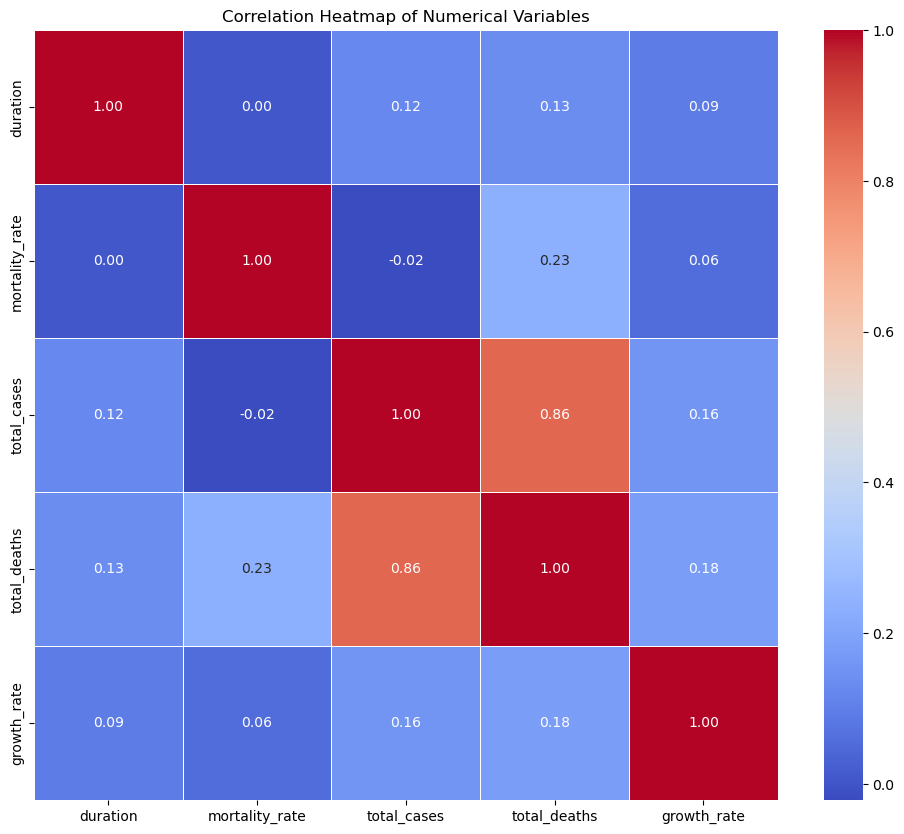

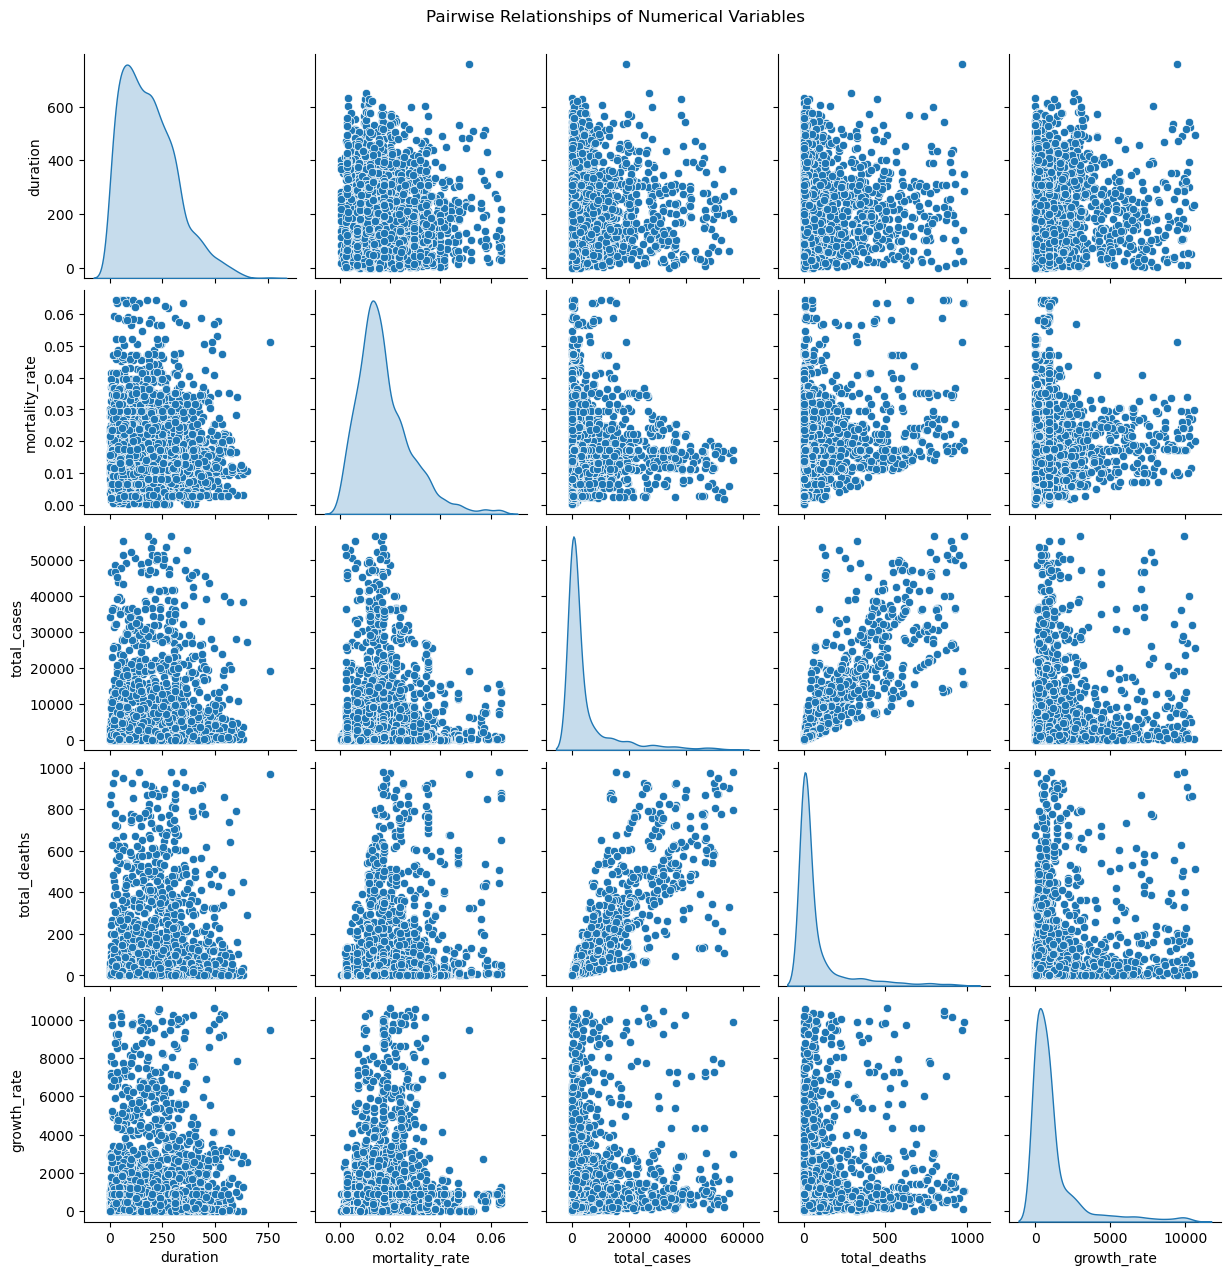


Pearson correlation between total_cases and total_deaths: 0.86
Pearson correlation between duration and mortality_rate: 0.00
Pearson correlation between growth_rate and total_cases: 0.16
--------------------------------------------------



In [7]:
#############################################
# Correlation Analysis
#############################################

# Compute correlation using only numeric columns
numeric_df = df.select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr()

# Print the correlation matrix
print("\nCorrelation Matrix:")
print(corr_matrix)

# Visualize the correlation matrix using a heatmap.
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Variables")
plt.show()

# Optionally, display a pairplot for an exploratory view of pairwise relationships.
# This will include scatter plots and distributions for each numeric variable.
numeric_cols = df.select_dtypes(include=[np.number]).columns
sns.pairplot(df[numeric_cols], diag_kind="kde")
plt.suptitle("Pairwise Relationships of Numerical Variables", y=1.02)
plt.show()

# Another option: Calculate and print the Pearson correlation coefficients directly for key variables.
# For example, to see the correlation between total_cases and total_deaths:
pearson_corr = df['total_cases'].corr(df['total_deaths'])
print(f"\nPearson correlation between total_cases and total_deaths: {pearson_corr:.2f}")

# Similarly, check correlations between duration, mortality_rate, and other metrics:
corr_duration_mort = df['duration'].corr(df['mortality_rate'])
print(f"Pearson correlation between duration and mortality_rate: {corr_duration_mort:.2f}")

corr_growth_tc = None
if 'growth_rate' in df.columns:
    corr_growth_tc = df['growth_rate'].corr(df['total_cases'])
    print(f"Pearson correlation between growth_rate and total_cases: {corr_growth_tc:.2f}")
print("--------------------------------------------------\n")


Using regression predictors: ['duration', 'mortality_rate', 'growth_rate']

--- Linear Regression ---
R2 Score: 0.04527602889116722
RMSE: 9443.540167501247


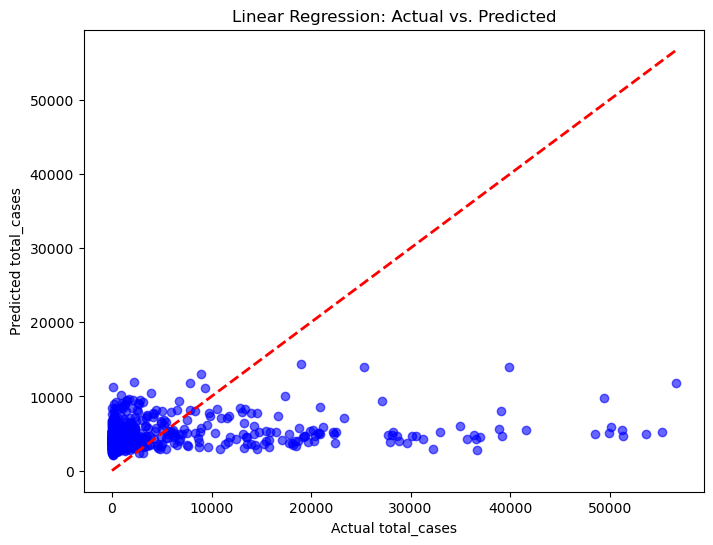


--- Ridge Regression ---
Best alpha: 0.1
R2 Score: 0.04504406634254976
RMSE: 9444.6873129968


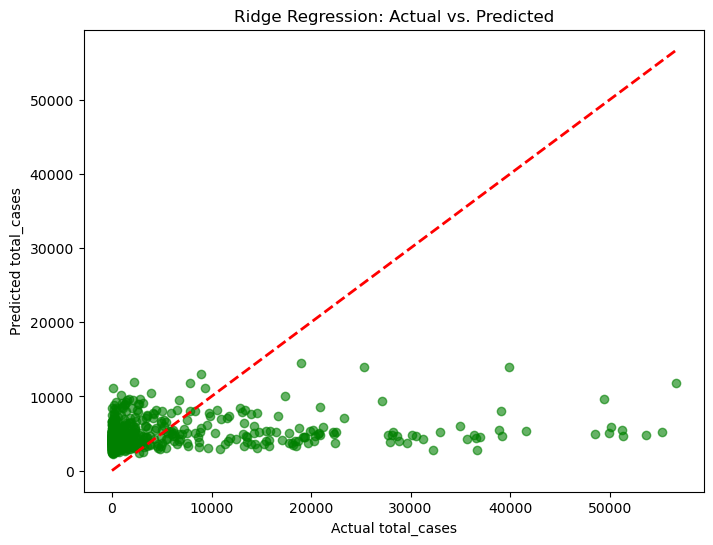


--- Lasso Regression ---
Best alpha: 0.01
R2 Score: 0.045273305222284566
RMSE: 9443.553637917268


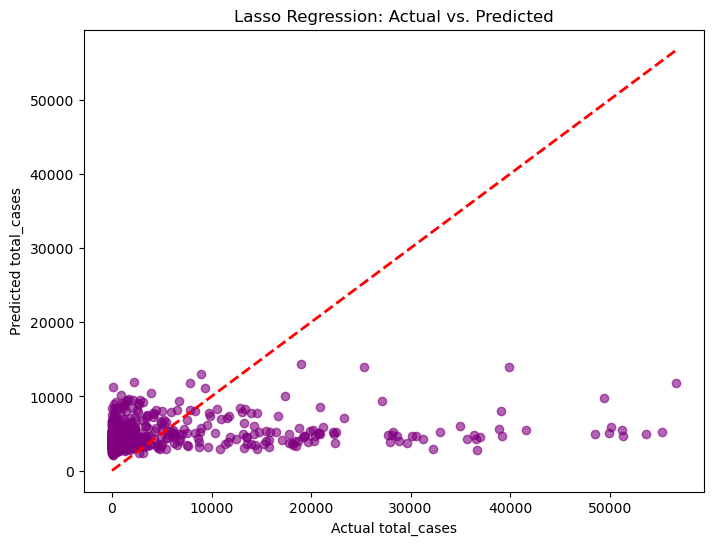


--- Principal Components Regression ---
Number of components used: 2
R2 Score: 0.04389530051309143
RMSE: 9450.366356765991


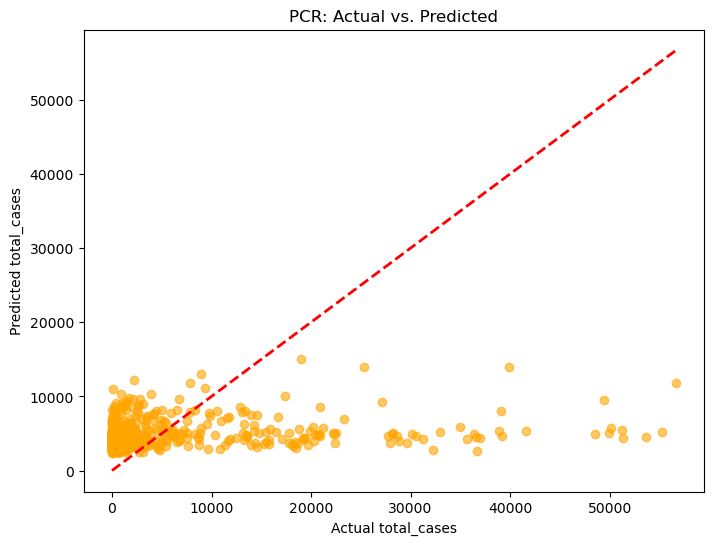

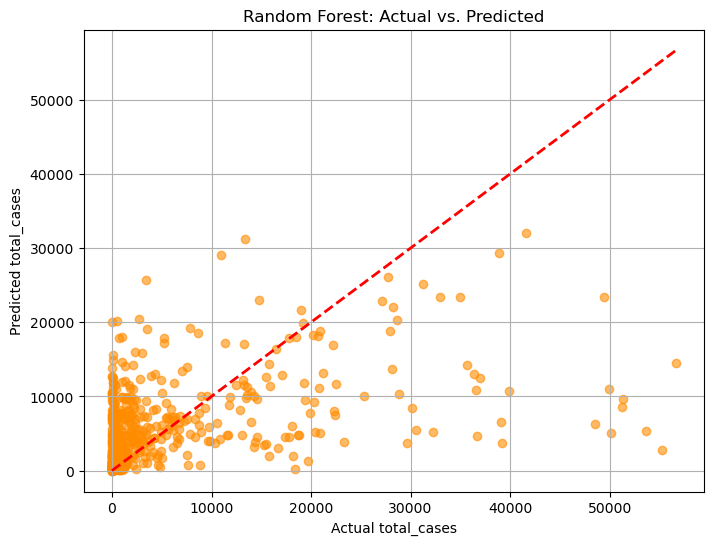

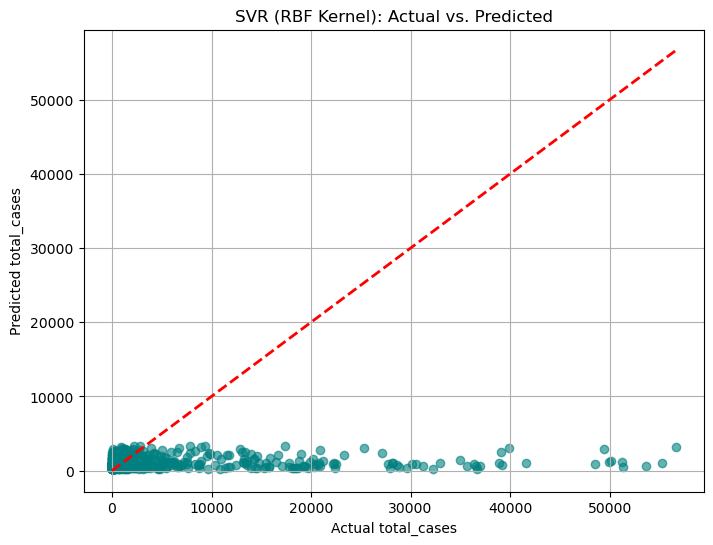


--- Random Forest Prediction ---
R2 Score: 0.22483665324973212
RMSE: 8509.274485176838

--- SVR Prediction ---
R2 Score: -0.15050206364982688
RMSE: 10366.678246879012

Median Mortality Rate: 0.015510485209207713
Classification predictors: ['total_cases', 'duration', 'growth_rate']

--- Logistic Regression Classification ---
Accuracy: 0.5048076923076923
Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.71      0.59       314
           1       0.50      0.30      0.37       310

    accuracy                           0.50       624
   macro avg       0.50      0.50      0.48       624
weighted avg       0.50      0.50      0.48       624

Confusion Matrix:
[[223  91]
 [218  92]]


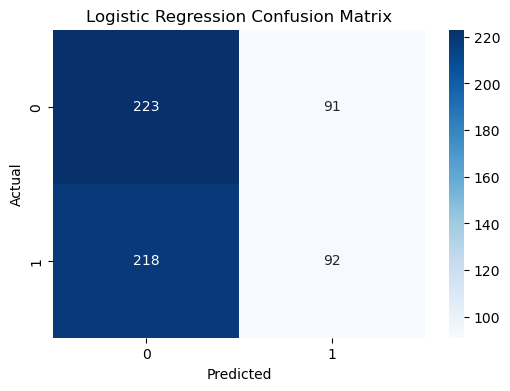

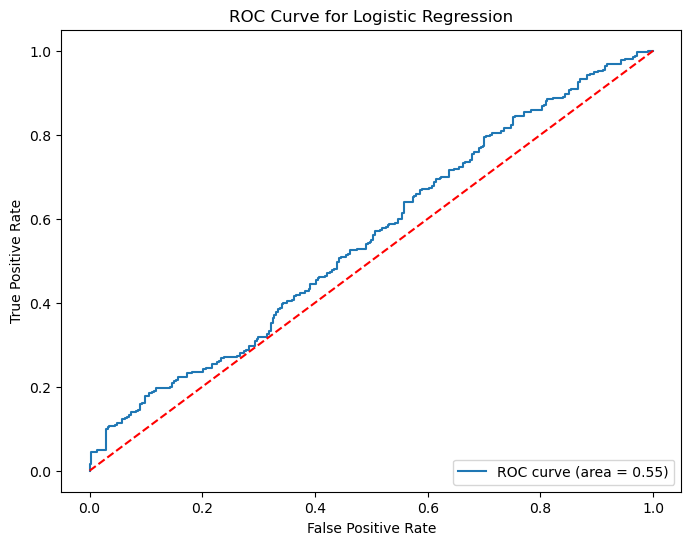


--- Decision Tree Classification ---
Accuracy: 0.5801282051282052
Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.64      0.61       314
           1       0.59      0.52      0.55       310

    accuracy                           0.58       624
   macro avg       0.58      0.58      0.58       624
weighted avg       0.58      0.58      0.58       624

Confusion Matrix:
[[201 113]
 [149 161]]


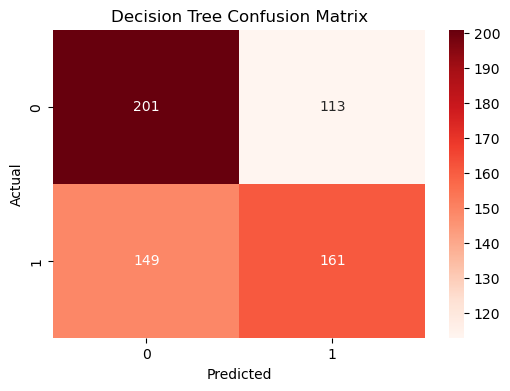

--------------------------------------------------



In [8]:
############################################
# Building Predictive and Classification Models
#############################################

# Regression Modeling: Predicting total_cases
# Select predictors and response for regression.
predictor_candidates = ['duration', 'mortality_rate', 'growth_rate']
predictors = [col for col in predictor_candidates if col in df.columns]
print("Using regression predictors:", predictors)

# Remove rows with missing values for the predictors and response.
df_model = df.dropna(subset=predictors + ['total_cases'])
X = df_model[predictors]
y = df_model['total_cases']

# Split the dataset into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

### Baseline Linear Regression ###
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print("\n--- Linear Regression ---")
print("R2 Score:", r2_score(y_test, y_pred_lr))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))

# Plot Actual vs Predicted for Linear Regression
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_lr, color='blue', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual total_cases")
plt.ylabel("Predicted total_cases")
plt.title("Linear Regression: Actual vs. Predicted")
plt.show()

### Ridge Regression ###
ridge = Ridge()
param_grid = {'alpha': np.logspace(-3, 3, 7)}
ridge_cv = GridSearchCV(ridge, param_grid, scoring='neg_mean_squared_error', cv=5)
ridge_cv.fit(X_train, y_train)
print("\n--- Ridge Regression ---")
print("Best alpha:", ridge_cv.best_params_['alpha'])
y_pred_ridge = ridge_cv.predict(X_test)
print("R2 Score:", r2_score(y_test, y_pred_ridge))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_ridge)))

# Plot Actual vs Predicted for Ridge Regression
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_ridge, color='green', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual total_cases")
plt.ylabel("Predicted total_cases")
plt.title("Ridge Regression: Actual vs. Predicted")
plt.show()

### Lasso Regression ###
lasso = Lasso(max_iter=10000)
param_grid = {'alpha': np.logspace(-3, 3, 7)}
lasso_cv = GridSearchCV(lasso, param_grid, scoring='neg_mean_squared_error', cv=5)
lasso_cv.fit(X_train, y_train)
print("\n--- Lasso Regression ---")
print("Best alpha:", lasso_cv.best_params_['alpha'])
y_pred_lasso = lasso_cv.predict(X_test)
print("R2 Score:", r2_score(y_test, y_pred_lasso))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lasso)))

# Plot Actual vs Predicted for Lasso Regression
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_lasso, color='purple', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual total_cases")
plt.ylabel("Predicted total_cases")
plt.title("Lasso Regression: Actual vs. Predicted")
plt.show()

### Principal Components Regression (PCR) ###
n_components = min(len(predictors), 2)
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
lr_pca = LinearRegression()
lr_pca.fit(X_train_pca, y_train)
y_pred_pca = lr_pca.predict(X_test_pca)
print("\n--- Principal Components Regression ---")
print(f"Number of components used: {n_components}")
print("R2 Score:", r2_score(y_test, y_pred_pca))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_pca)))

# Plot Actual vs Predicted for PCR
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_pca, color='orange', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual total_cases")
plt.ylabel("Predicted total_cases")
plt.title("PCR: Actual vs. Predicted")
plt.show()

# Nonlinear Relationships

# Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

# Support Vector Regressor (with scaling)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svr = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
svr.fit(X_train_scaled, y_train)
y_pred_svr = svr.predict(X_test_scaled)
r2_svr = r2_score(y_test, y_pred_svr)
rmse_svr = np.sqrt(mean_squared_error(y_test, y_pred_svr))

# Plot: Random Forest Predictions
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_rf, color='darkorange', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual total_cases")
plt.ylabel("Predicted total_cases")
plt.title("Random Forest: Actual vs. Predicted")
plt.grid(True)
plt.show()

# Plot: SVR Predictions
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_svr, color='teal', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual total_cases")
plt.ylabel("Predicted total_cases")
plt.title("SVR (RBF Kernel): Actual vs. Predicted")
plt.grid(True)
plt.show()

print("\n--- Random Forest Prediction ---")
print ("R2 Score:", r2_rf)
print("RMSE:", rmse_rf) 
    
print("\n--- SVR Prediction ---")
print ("R2 Score:", r2_svr)
print ("RMSE:", rmse_svr)

#############################################
# Classification Modeling: Predicting High Mortality
#############################################

# Create a binary target variable 'high_mortality'
median_mort = df['mortality_rate'].median()
df['high_mortality'] = (df['mortality_rate'] > median_mort).astype(int)
print("\nMedian Mortality Rate:", median_mort)

# Choose classification predictors.
predictor_candidates_class = []
if 'total_cases' in df.columns:
    predictor_candidates_class.append('total_cases')
if 'duration' in df.columns:
    predictor_candidates_class.append('duration')
if 'growth_rate' in df.columns:
    predictor_candidates_class.append('growth_rate')
print("Classification predictors:", predictor_candidates_class)

X_class = df[predictor_candidates_class].dropna()
y_class = df.loc[X_class.index, 'high_mortality']

Xc_train, Xc_test, yc_train, yc_test = train_test_split(X_class, y_class, test_size=0.20, random_state=42)

# Standardize predictors for logistic regression.
scaler = StandardScaler()
Xc_train_scaled = scaler.fit_transform(Xc_train)
Xc_test_scaled = scaler.transform(Xc_test)

### Logistic Regression Classifier ###
logreg = LogisticRegression()
logreg.fit(Xc_train_scaled, yc_train)
yc_pred_logreg = logreg.predict(Xc_test_scaled)
print("\n--- Logistic Regression Classification ---")
print("Accuracy:", accuracy_score(yc_test, yc_pred_logreg))
print("Classification Report:")
print(classification_report(yc_test, yc_pred_logreg))
print("Confusion Matrix:")
print(confusion_matrix(yc_test, yc_pred_logreg))

# Plot Confusion Matrix for Logistic Regression
cm_lr = confusion_matrix(yc_test, yc_pred_logreg)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap="Blues")
plt.title("Logistic Regression Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve for Logistic Regression
yc_pred_prob_logreg = logreg.predict_proba(Xc_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(yc_test, yc_pred_prob_logreg)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Logistic Regression")
plt.legend(loc="lower right")
plt.show()

### Decision Tree Classifier ###
dtree = DecisionTreeClassifier(random_state=42)
dtree.fit(Xc_train, yc_train)  # Decision trees do not require scaling.
yc_pred_dtree = dtree.predict(Xc_test)
print("\n--- Decision Tree Classification ---")
print("Accuracy:", accuracy_score(yc_test, yc_pred_dtree))
print("Classification Report:")
print(classification_report(yc_test, yc_pred_dtree))
print("Confusion Matrix:")
print(confusion_matrix(yc_test, yc_pred_dtree))

# Plot Confusion Matrix for Decision Tree
cm_dt = confusion_matrix(yc_test, yc_pred_dtree)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap="Reds")
plt.title("Decision Tree Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("--------------------------------------------------\n")